<img src="//tiny.cc/devnetlogo" alt="Logo">
    
# Cisco Connect 2020 - Security Use case Click-through Demo

Welcome to the DevNet click through demo. 



## Getting Started with Cisco Security solutions
### What security solutions do you use today?

#### SecureX?
<img width=70% src="https://www.cisco.com/c/en/us/products/security/securex/_jcr_content/Grid/category_atl_1a3/layout-category-atl/spotlight_1866905668.img.png/1582303582188.png">

Maybe not yet...

Security operators and analysts, especially investigators and incident responders, have a wide and increasingly complex variety of tools at their disposal. Each of these has a different user interface and user experience. Switching between interfaces and contexts is needlessly distracting and time consuming.

<img width=70% src="https://www.cistor.com/wp-content/uploads/2019/05/talos-security-image-1024x570.jpg">


Threat Response aims to mitigate that problem by bringing threat intelligence, local telemetry context, and the first-strike response capabilities of multiple products into one easy to use interface, to allow our customers to use their existing Cisco investments more efficiently and effectively.

Out of the box TR integrates with the following secuirity products

|Integrated products|Description|
|---|---|
|Umbrella|Insights or Platform|
|Firepower devices|Firepower software v6.3 or higher|
|Email Secuirty |SMA-managed, v12.0 or higher or standalone |
|Stealthwatch Enterprise|v.7.1.2+|
|Web Security |SMA-managed or standalone|
|Orbital|With AMP for Endpoints Advantage|
|AMP for Endpoints|Portal|
|Threat Grid|Portal|

Today's DevNet demo is going to focus on Threat Response and show you how you can leverage it's open API's to automate your workflows even further

## Threat Response API's

Cisco Threat Response is written "API first." This means that the API endpoint that performs a task is written, and then the UI component is written that calls that API endpoint. The entire user interface of CTR is itself an API client - a user of the same APIs to which you also have direct access. Anything you can perform in the UI, you can also perform via the API, by definition.

The APIs are organized by task area. Each takes inputs in JSON format, and returns data in JSON format. Each, where applicable, conforms to Cisco Threat Intelligence Model (CTIM) formatting for that data. This data structure is well defined, well documented, and based on the industry standard STIX model.

"The Threat Response API" is actually several APIs, broken out by a logical separation of functions:

|Category|Description|
|---|---|
|Inspect | pull observables out of formatted or unformatted text|
|Enrich | search for additional information about those observables|
|Response | take actions on observables (for example, add to blocklist)|
|Settings | configure Threat Response|
|Oauth | use credentials and get access tokens|
|Global intel | read global threat intelligence|
|Private intel | read and write user-provided threat intelligence|

All of the APIs live at the root location /iroh/, followed by the name of the API, such as /iroh/inspect/

Threat Response also have very extensive help guides https://visibility.amp.cisco.com/help/integration


## 1. API Swagger Documentation
The menu of APIs in the help doc above links to the Swagger documentation for each API. Swagger is an open source API development suite that includes the ability to have API developers create documentation alongside the code itself. The automatically generated Swagger documentation even includes prototyping capabilities, because the documentation backend includes a built-in client for that API.

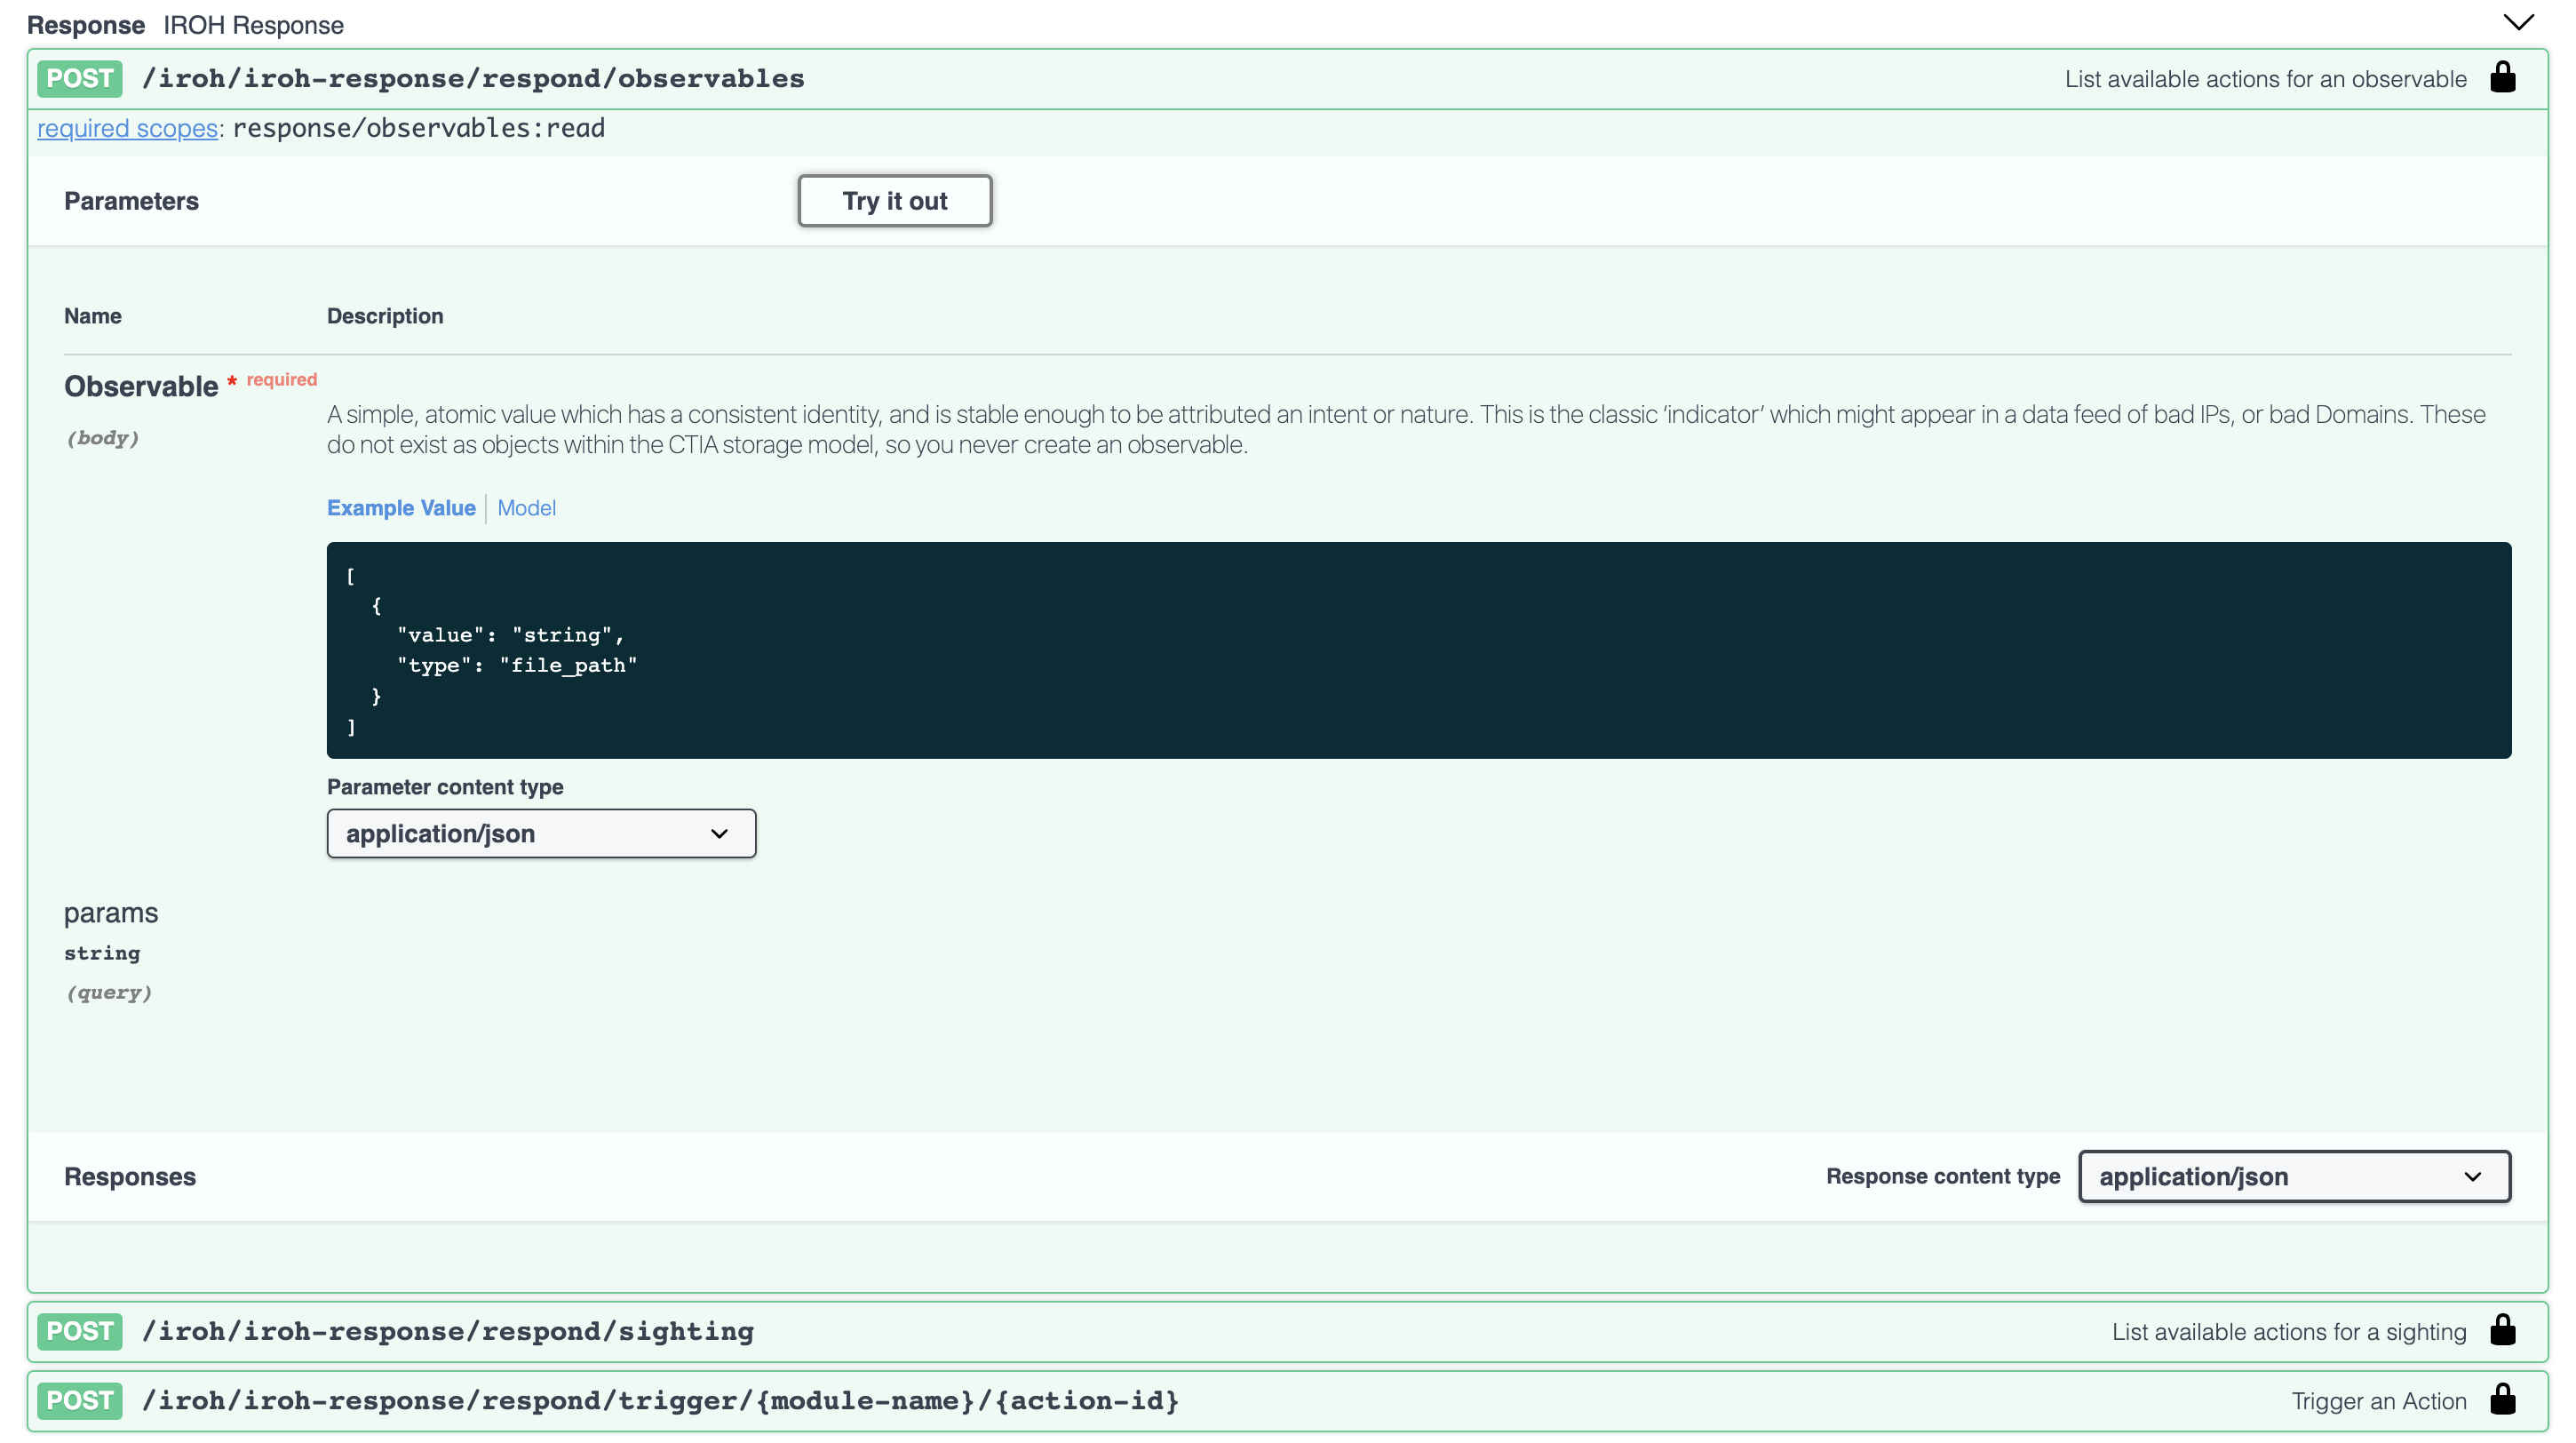

Click the Try Now and you will see example curl commands, Request URL, and response. You can easily use these information for your own program

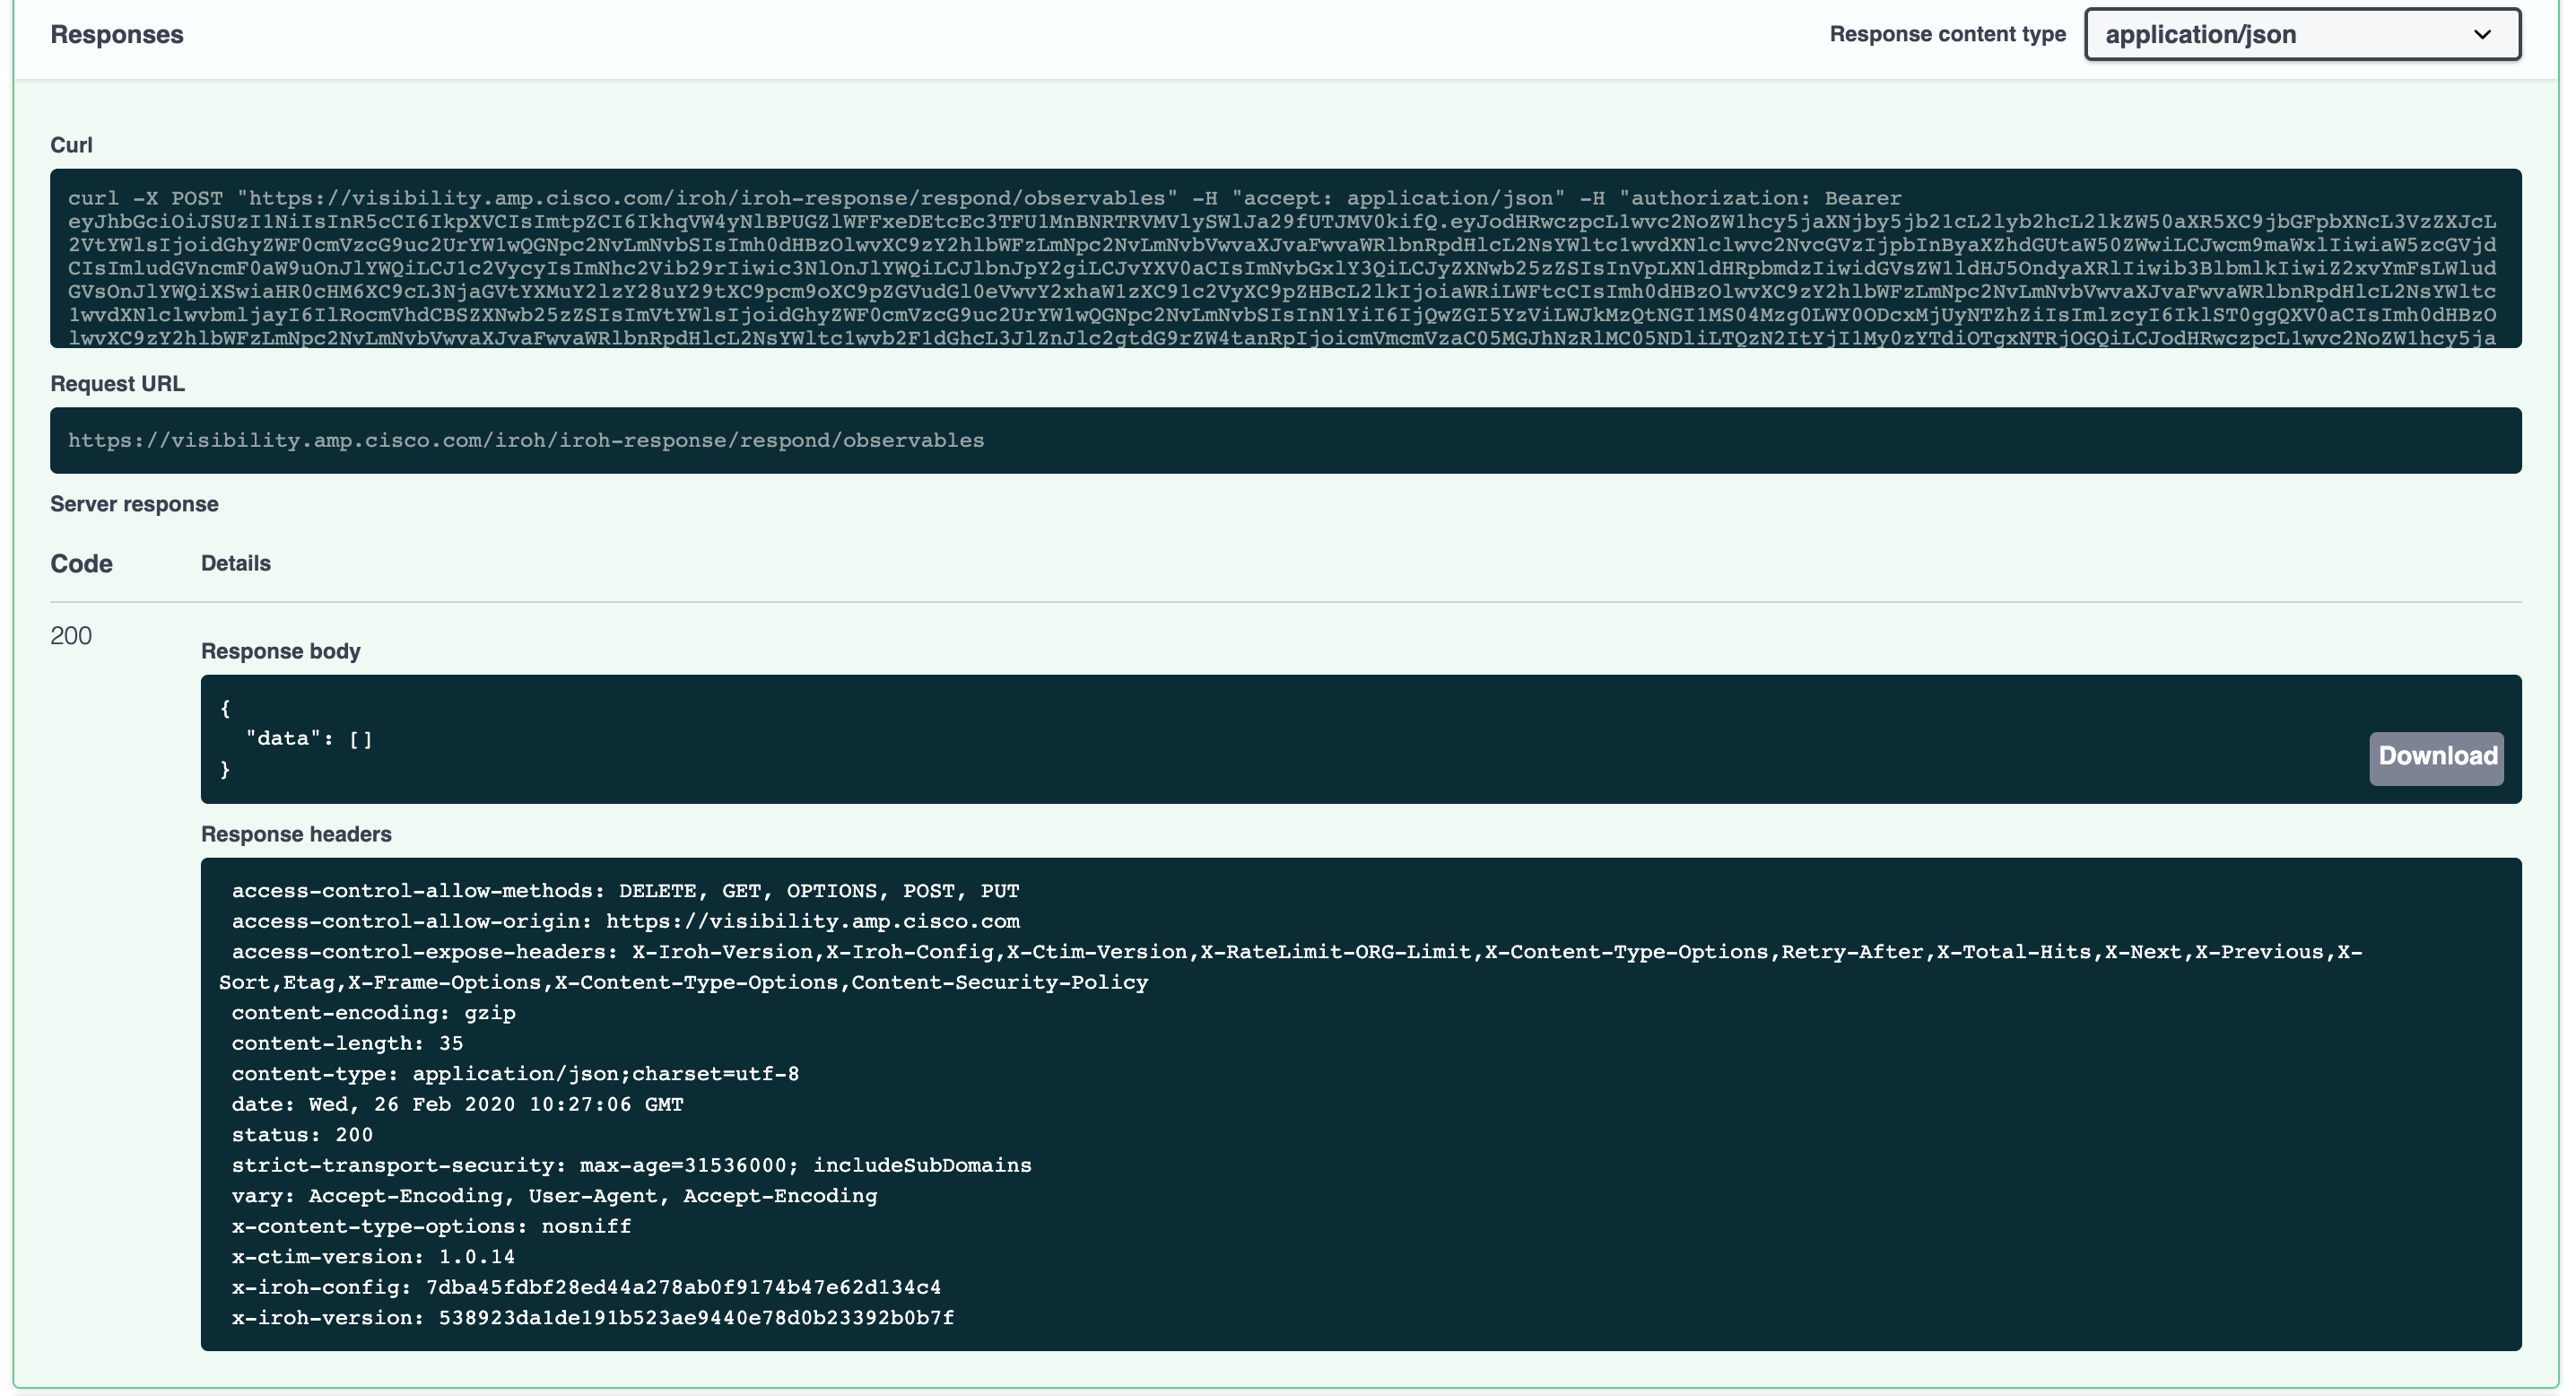

## 2. Threat Response Concepts and Terminology
There are a number of concepts used when discussing what Threat Response does and how it does it. Familiarity with these concepts is going to be key to your success at leveraging the platform, either via the UI or the API, to achieve those goals. Review the glossary below.

|Term|Meaning|
|---|---|
|Module | a pluggable and configurable code component that handles API communication with an integrated product or data source|
|Observable | any identifiable network or system artifact that can be observed. Eg; File hashes, IP and other addresses, user accounts, etc|
|Judgement | an opinion held by an integrated product or data source about an observable at a given time|
|Verdict | a single Judgement deemed by Threat Response to be the most accurate/trustworthy at the current time|
|Sighting | an observation of an observable. For example, an endpoint detecting a file hash detected on a filesystem, or on the network by a firewall|
|Target | a system that interacted with an observable. All local sightings will involve one or more targets|
|CTIM | Cisco Threat Intelligence Model. A data model that lays out items, parameters, and relationships, in order to encapsulate security knowledge|
|CTIA | Cisco Threat Intelligence Architecture. An instance of a database housing data in CTIM format|
|Scopes | Granular permissions that control what various user accounts and API clients can do. For example, trigger responses or write to the private data store|

## 3. Let's start coding - Get authenticated
CTR use Oauth 2.0 for authentication. The API Client ID and password, was obtained and stored in a config file, however they are not what grant access to the APIs directly. You use those with the Authentication API to request, receive, and present time-limited authentication tokens.

The authentication flow is as follows:

- Use your ClientID and Password to obtain a token
- Use the token to access the APIs for all other functions
- When the token expires, request a new token with your API ClientID and password
- Use the new token to continue using the APIs for all other functions, until it expires
- Repeat steps 3-4 as needed

The following section of code shows you how authentication token is aquired

In [ ]:
### How to execute this code: Highlight this cell, then press "Shift+Return(Enter)"
### This section imports the modules we needed
import os
import json
import requests
from datetime import datetime
import webexteamssdk
import utils                                                            #Import the credentials and other info from pre-configured file

This imports the modules and information we need for connecting to CTR, no output expected

In [ ]:
### Open config file
def open_config():
    '''
    this function opens config file
    '''
    if os.path.isfile("config.json"):
        global config_file
        with open("config.json", 'r') as config_file:
            config_file = json.loads(config_file.read())
            print("\nThe config file was loaded.\n")
    else:
        print("No config.json file, please make sure config.json file is in same directory.\n")
        
### Define a functioon that gets CTR access token
def get_CTR_access_token():
    ''' 
    This function requests access token for OAuth2 for other CTR API requests
    '''
    #error checking for API client details
    if config_file['client_id']:
        client_id = config_file['client_id']
    else:
        print("client_id is missing in config.json file...\n")

    if config_file['client_secret']:
        client_secret = config_file['client_secret']
    else:
        print("client_secret is missing in config.json file...\n")


    # create headers for access token request
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Accept': 'application/json',
    }

    data = {
    'grant_type': 'client_credentials'
    }

    # create headers for access token request
    response = requests.post('https://visibility.amp.cisco.com/iroh/oauth2/token', headers=headers, data=data, auth=(client_id, client_secret))

    #check if request was succesful
    if response.status_code == 200:
        
        # grab the text from the request
        rsp_dict = json.loads(response.text)
        # retrieve variables from text, global variable so that it can be used by all functions for CTR
        access_token = (rsp_dict['access_token'])
        scope = (rsp_dict['scope'])
        expiration_time = (rsp_dict['expires_in'])     
        # user feedback
        #print(f"[200] Success, access_token generated! This is the scope: {scope}. Expires in: {expiration_time} seconds.\n") 
        
        # return token
        return access_token
    else:
        # user feedback
        print(f"Access token request failed, status code: {response.status_code}\n")



Above is just declareration of the functions, there will be no output (if you're looking for one)
Let's try the functions and see if the token can be obtained

In [ ]:
# First we open the config file with the first function
open_config()
# Second we obtain the token with the second function
token=get_CTR_access_token()
# Then we display the token with Print function below
print (token)                                                                                       #Print out the token to view

After running the line above, you should see the token displayed. Now we've authenticated and aquired the token, we can explore the other API's

---

## 4. Collect TALOS blogs and look for observables to create casebooks

Now let's have this script browse through some current feeds of Talos blogs, usually there are observables at the end of the post as we show cased in the demo. Let's get the script to browse through the post for us and locate observables to create casebooks for us.

The following loop looks for different feeds (not only limited to Cisco Talos, it can also look for unit42 and fortinet and other feeds too!)


In [ ]:
try:
    # open config json file and grab client_id and secret
    open_config()
     
    # activate the RSS feed parser for the Talos blog
    for rss_feed_index, rss_feed in enumerate(config_file['url_feeds']):
        casebook_data=utils.parse_rss_feed(rss_feed,rss_feed_index,config_file,token)
        if casebook_data != []:
            break

except KeyboardInterrupt:
    print("\nExiting...\n")
    
# Please be patient and wait for a minute or two, it might take up to 5 mins
# When you see "Feed analysis found one instance, ready to create casebook", then you can move on!

---

Please wait a minute before you continue. Wait for <font color=yellow>"Please move on ===>"</font>

---


## 5. Finally we create a new casebook

Now we're ready to create a new casebook with the return of the last call

When this call is successful, you'll get a notification from WebEx teams

In [ ]:
# create headers for API request
bearer_token = 'Bearer ' + get_CTR_access_token() 
headers = {
    'Authorization': bearer_token,
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}

# create title and description for SOC researcher to have more context, if there are sightings, add high priority
feed_name=casebook_data[0]
returned_observables_json=casebook_data[1]
returned_sightings=casebook_data[2]
entry_title=casebook_data[3]
entry_link=casebook_data[4]

if returned_sightings['total_sighting_count'] == 0:
    casebook_title = feed_name + ": " + entry_title
if returned_sightings['total_sighting_count'] != 0:
    casebook_title = "*HIGH PRIORITY* " + feed_name + ": " + entry_title

casebook_description = "Python generated casebook from: " + feed_name + ". Link to blogpost: " + entry_link
casebook_datetime = datetime.now().isoformat() + "Z"

# create right json format to create casebook
casebook_json = json.dumps({
    "title": casebook_title,
    "description": casebook_description,
    "observables": json.loads(returned_observables_json),
    "type": "casebook",
    "timestamp": casebook_datetime   
})

# post request to create casebook
response = requests.post('https://private.intel.amp.cisco.com/ctia/casebook', headers=headers, data=casebook_json)
if response.status_code == 201:
    print(f"[201] Success, casebook added from {feed_name}: {entry_title}\n")
    
    # if Webex Teams tokens set, then send message to Webex room
    if config_file['webex_access_token'] is '' or config_file['webex_room_id'] is '':

        # user feed back
        print("Webex Teams not set.\n\n")
    else:            
        # instantiate the Webex handler with the access token
        teams = webexteamssdk.WebexTeamsAPI(config_file['webex_access_token'])

        # post a message to the specified Webex room 
        try:
            if returned_sightings['total_sighting_count'] == 0:
                webex_text = feed_name + " New case has been added to casebook from RSS Feed: " + entry_title
                message = teams.messages.create(config_file['webex_room_id'], text=webex_text) 
            if returned_sightings['total_sighting_count'] != 0:
                webex_text = feed_name + " New case has been added to casebook from RSS Feed: " + entry_title + ". 🚨🚨🚨  HIGH PRIORITY, Target Sightings have been identified! AMP targets: " + str(returned_sightings['total_amp_sighting_count']) + ", Umbrella targets: " + str(returned_sightings['total_umbrella_sighting_count']) + ", Email targets: " + str(returned_sightings['total_email_sighting_count']) + ". 🚨🚨🚨"
                message = teams.messages.create(config_file['webex_room_id'], text=webex_text)
        # error handling, if for example the Webex API key expired
        except Exception:
            print("Webex authentication failed... Please make sure Webex Teams API key has not expired. Please review developer.webex.com for more info.\n")
else:
    print(f"Something went wrong while posting the casebook to CTR, status code: {response.status_code}\n")

Now this script is almost complete. Make it a loop so it will keep monitoring and generate casebooks.
When there's a new post, you will get a notification in WebEx teams and a casebook is already created for you on CTR.
Now all you need to do is enjoy life :)

---

## 6. MISSION - Challenge for you! - Check sighting and post to WebEx teams

Apply the following template to a device.
You can modify the line below.

We intentionly replaced some fields below and named them <font color=yellow>**<<[[MISSION]]>>**</font> for you to figure out what it should be

---

In [ ]:
# create headers for API request
bearer_token = 'Bearer ' + get_CTR_access_token()

headers = {
    'Authorization': bearer_token,
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}

j = [ { "value": "0dc7438be5b21a36651de0a08361b18d76f0920517a7d51f75dc234740f392ca", "type": "sha256" } ] 
data = json.dumps(j)


response = requests.post('https://visibility.amp.cisco.com/iroh/iroh-enrich/observe/<<[[MISSION]]>>', headers=headers, data=data)

#check if request was succesful
if response.status_code == 200:
    
    returned_data = json.loads(response.text)

    total_amp_sighting_count = 0
    total_amper_sighting_count = 0
    total_umbrella_sighting_count = 0
    total_email_sighting_count = 0

    # run through all modules to check for sightings (currently checking the amp, umbrella and SMA modules)
    for module in returned_data['data']:
        if module['module'] == "AMP File Reputation":
            # json key not always there, error checking...
            if 'sightings' in module['data']:
                # store amount of sightings
                total_amp_sighting_count = module['data']['sightings']['count']
        
        if module['module'] == "AMP EDR":
            # json key not always there, error checking...
            if 'sightings' in module['data']:
                # store amount of sightings
                total_amper_sighting_count = module['data']['sightings']['count']

        if module['module'] == "Umbrella":
            # json key not always there, error checking...
            if 'sightings' in module['data']:
                # store amount of sightings
                total_umbrella_sighting_count = module['data']['sightings']['count']

        if module['module'] == "SMA Email":
            # json key not always there, error checking...
            if 'sightings' in module['data']:
                # store amount of sightings
                total_email_sighting_count = module['data']['sightings']['count']

    # create dict to store information regarding the sightings

    total_sighting_count = total_amp_sighting_count + total_amper_sighting_count +total_umbrella_sighting_count + total_email_sighting_count
print ("Total sightings count = ", total_sighting_count)



---
***Note***: Make sure you got the correct output above, before you move on...

---


In [ ]:
# Publish the data to WebEx teams

# if Webex Teams tokens set, then send message to Webex room
if config_file['webex_access_token'] is '' or config_file['webex_room_id'] is '':

    # user feed back
    print("Webex Teams not set.\n\n")
else:            
    # instantiate the Webex handler with the access token
    teams = webexteamssdk.WebexTeamsAPI(config_file['webex_access_token'])

    # post a message to the specified Webex room 
    try:
        if total_sighting_count == 0:
            webex_text = " No sighting found: "
            message = teams.messages.create(config_file['webex_room_id'], text=webex_text) 
        if total_sighting_count != 0:
            webex_text = ". 🚨🚨🚨  HIGH PRIORITY, Target Sightings have been identified! Endpoint Detection and Response: " + str(total_amper_sighting_count) + ", AMP targets: " + str(total_amp_sighting_count) + ", Umbrella targets: " + str(total_umbrella_sighting_count) + ", Email targets: " + str(total_email_sighting_count) + ". 🚨🚨🚨"
            message = teams.messages.create(config_file['webex_room_id'], text=webex_text)
    # error handling, if for example the Webex API key expired
    except Exception:
        print("Webex authentication failed... Please make sure Webex Teams API key has not expired. Please review developer.webex.com for more info.\n")

---

--- END OF LAB ---

---